# 2. Linear Regression Analysis

## Setup

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline 

In [2]:
# Load data
ames_clean = pd.read_csv('data/Ames_Housing_Price_Data_clean.csv')

In [3]:
# Create the independent variables and the target
predictors = ames_clean.drop('SalePrice', axis=1)
target = ames_clean['SalePrice']

In [4]:
print(predictors.columns.sort_values())

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr',
       'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st',
       'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation',
       'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea',
       'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenAbvGr',
       'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig',
       'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning',
       'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold',
       'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual',
       'PavedDrive', 'PoolArea', 'PoolQC',

In [5]:
# Categorize columns of the independent variables
numeric_columns = predictors.select_dtypes(['int64', 'uint8', 'float64']).columns
categorical_columns = predictors.columns.difference(numeric_columns)

## Key Assumptions of Linear Regression

Linear Regression has several key assumptions:
1. **Linearity** - there should be a linear relationship between the independent (predictor) variables and the dependent (response) variable
2. **Independence of Errors** - residuals should be independent of each other with no correlation
3. **Homoscedasticity** - residuals should have constant variance across the range of predicted values
4. **Normality of errors** - residuals should be approximiately normally distributed
5. **No or little multicollinearity** - independent variables should not be highly correlated with each other

## Check for Multicollinearity

We will check for multicollinearity first given the large number of features

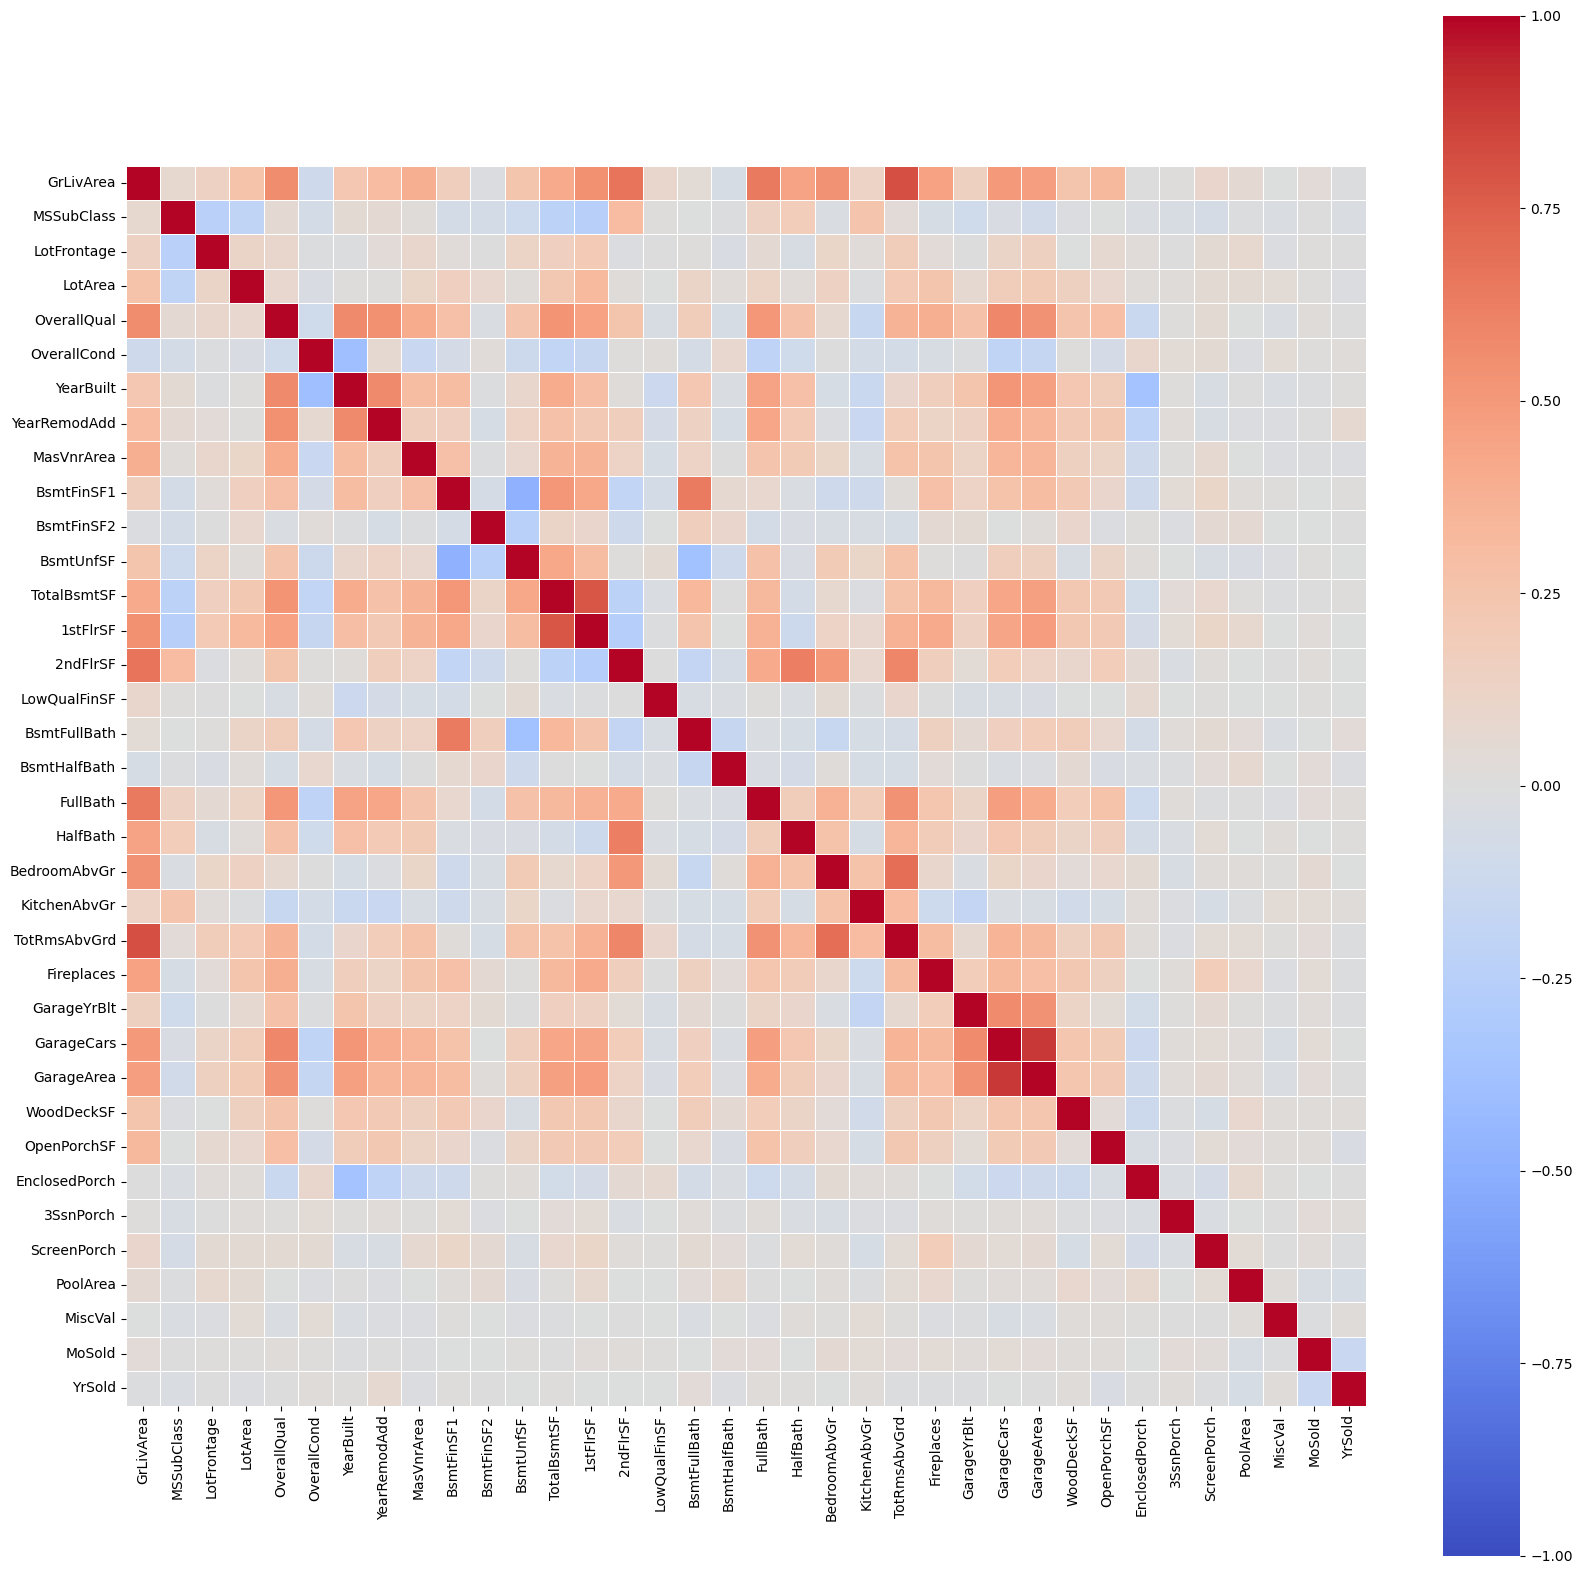

In [6]:
# Plot the correlation matrix
correlation_matrix = predictors.corr()

plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, square=True, cmap='coolwarm', fmt='.2f', vmax=1.0, vmin=-1.0, linewidths=0.5)
plt.show()

In [7]:
# Calculate the variance inflation factor (VIF) for each independent variable
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(predictors.loc[:,numeric_columns].values, i) 
              for i in range(predictors.loc[:,numeric_columns].shape[1])]

# Print the column names and their VIF values
vif = vif.assign(Feature=predictors[numeric_columns].columns)
vif.sort_values(by='VIF', ascending=False, inplace=True)
print(vif)

             VIF        Feature
0            inf      GrLivArea
9            inf     BsmtFinSF1
15           inf   LowQualFinSF
14           inf       2ndFlrSF
13           inf       1stFlrSF
12           inf    TotalBsmtSF
11           inf      BsmtUnfSF
10           inf     BsmtFinSF2
35  2.187306e+04         YrSold
7   2.050288e+04   YearRemodAdd
6   1.601022e+04      YearBuilt
22  8.192805e+01   TotRmsAbvGrd
4   6.161835e+01    OverallQual
21  4.355915e+01   KitchenAbvGr
5   4.122175e+01    OverallCond
25  4.079507e+01     GarageCars
24  3.375221e+01    GarageYrBlt
26  3.265976e+01     GarageArea
20  3.150878e+01   BedroomAbvGr
18  2.513003e+01       FullBath
34  6.415666e+00         MoSold
2   4.388902e+00    LotFrontage
1   4.243464e+00     MSSubClass
16  3.624166e+00   BsmtFullBath
19  3.451496e+00       HalfBath
3   3.116483e+00        LotArea
23  2.926793e+00     Fireplaces
27  1.903430e+00     WoodDeckSF
8   1.810977e+00     MasVnrArea
28  1.778288e+00    OpenPorchSF
29  1.37

/Users/georgeho/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


## Feature Engineering and Selection

Given the significant presence of multicollinearity, we will build the feature set "bottoms up."  One way to do that is relying upon domain expertise.

See:  https://www.opendoor.com/articles/factors-that-influence-home-value

This article lists several features that "conventional wisdom" deems important in determining a home's value:
1. Location
2. Home size and usable space
3. Age and condition
4. Upgrades and updates
5. The local market
6. Economic indicators
7. Interest rates

We will look for proxy variables in the dataset for each one, testing for (a) predictive performance and (b) minimization of multicollinearity on the whole set.

In [11]:
# Create linear regression object
lr = LinearRegression()

#### Location proxy features

*Candidates:*
- Neighborhood: Physical locations within Ames city limits

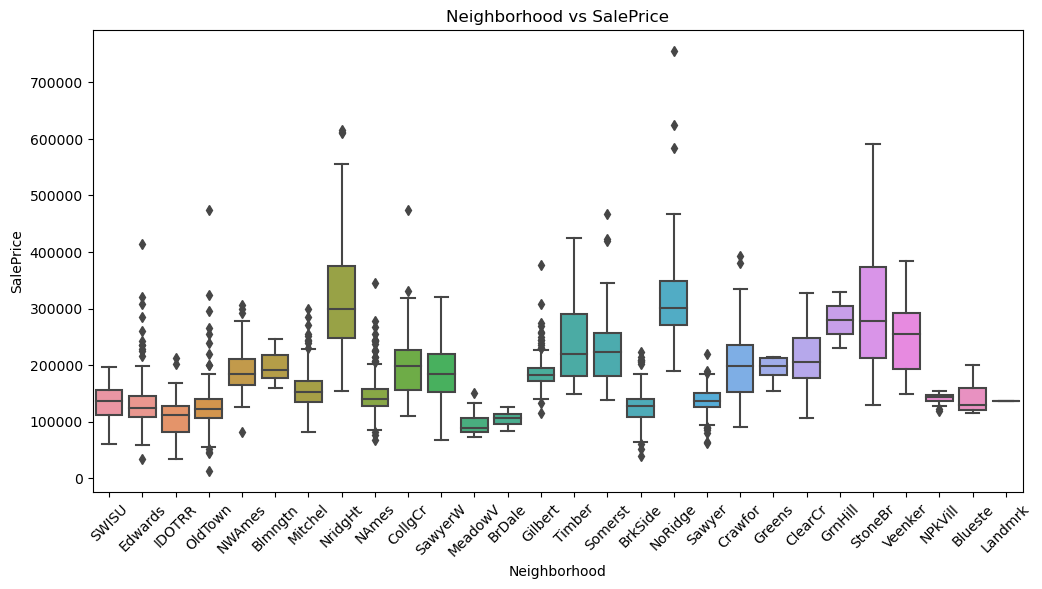

In [12]:
# Create a box plot of SalePrice for each neighborhood
plt.figure(figsize=(12, 6))
sns.boxplot(x='Neighborhood', y='SalePrice', data=ames_clean)

# Label the plot
plt.title('Neighborhood vs SalePrice')
plt.xlabel('Neighborhood')
plt.ylabel('SalePrice')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [13]:
# Dummify the 'Neighborhood' column
neighborhood_dummies = pd.get_dummies(predictors['Neighborhood'], prefix='Neighborhood')

# Drop the first column of neighborhood_dummies
neighborhood_dummies = neighborhood_dummies.drop('Neighborhood_Blmngtn', axis=1)

neighborhood_dummies.head()

,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,...,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Fit the model
lr.fit(neighborhood_dummies, target)

# Show the R^2 score
lr.score(neighborhood_dummies, target)

0.5598045031837189

#### Home Size and Usable Space proxy features

*Candidates:*
- LotArea: Lot size in square feet
- GrLivArea: Above grade (ground) living area square feet
- TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)

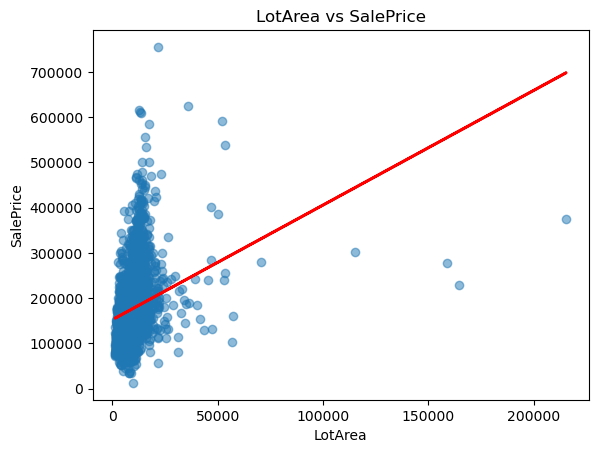

R^2 = 0.07531013997565805


In [38]:
# Plot and score LotArea

# Fit the model
lr.fit(predictors[['LotArea']], target)

# Create scatter plot
plt.scatter(predictors['LotArea'], target, alpha=0.5)

# Plot the regression line
plt.plot(predictors['LotArea'], lr.predict(predictors[['LotArea']]), color='red', linewidth=2)

# Label the plot
plt.title('LotArea vs SalePrice')
plt.xlabel('LotArea')
plt.ylabel('SalePrice')

# Show the plot
plt.show()

# Show scores
print(f"R^2 = {lr.score(predictors[['LotArea']], target)}")

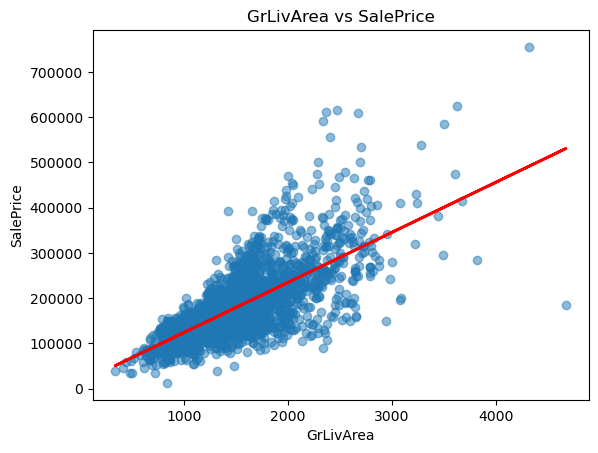

R^2 = 0.5183711142112821


In [39]:
# Plot and score GrLivArea

# Fit the model
lr.fit(predictors[['GrLivArea']], target)

# Create scatter plot
plt.scatter(predictors['GrLivArea'], target, alpha=0.5)

# Plot the regression line
plt.plot(predictors['GrLivArea'], lr.predict(predictors[['GrLivArea']]), color='red', linewidth=2)

# Label the plot
plt.title('GrLivArea vs SalePrice')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')

# Show the plot
plt.show()

# Show scores
print(f"R^2 = {lr.score(predictors[['GrLivArea']], target)}")

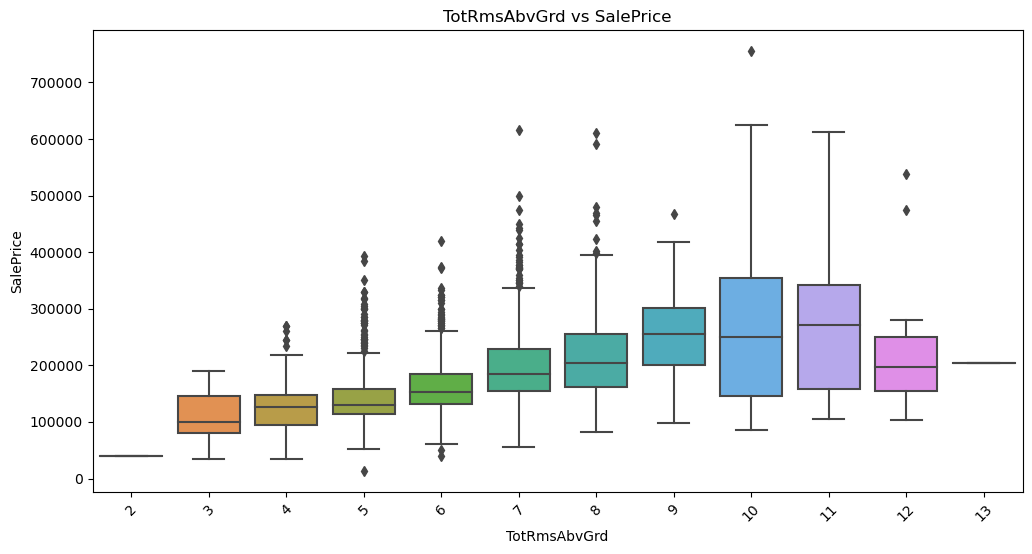

In [40]:
# Create a box plot of SalePrice vs. TotRmsAbvGrd
plt.figure(figsize=(12, 6))
sns.boxplot(x='TotRmsAbvGrd', y='SalePrice', data=ames_clean)

# Label the plot
plt.title('TotRmsAbvGrd vs SalePrice')
plt.xlabel('TotRmsAbvGrd')
plt.ylabel('SalePrice')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [41]:
# Dummify the 'TotRmsAbvGrd' column
totrms_dummies = pd.get_dummies(predictors['TotRmsAbvGrd'], prefix='TotRmsAbvGrd')

# Drop the first column
totrms_dummies = totrms_dummies.drop('TotRmsAbvGrd_2', axis=1)

totrms_dummies.head()

,TotRmsAbvGrd_3,TotRmsAbvGrd_4,TotRmsAbvGrd_5,TotRmsAbvGrd_6,TotRmsAbvGrd_7,TotRmsAbvGrd_8,TotRmsAbvGrd_9,TotRmsAbvGrd_10,TotRmsAbvGrd_11,TotRmsAbvGrd_12,TotRmsAbvGrd_13
0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0


In [43]:
# Fit the model
lr.fit(totrms_dummies, target)

# Show the R^2 score
print(f"R^2 = {lr.score(totrms_dummies, target)}")

R^2 = 0.2525535970892827


#### Age proxy features

*Candidates:*
- YearBuilt: Original construction date

In [44]:
# Create a new feature representing YearsSinceBuilt
YearsSinceBuilt = max(predictors['YearBuilt']) - predictors['YearBuilt']
age = pd.DataFrame({'YearsSinceBuilt': YearsSinceBuilt})

In [45]:
# Fit the model
lr.fit(age, target)

# Show the R^2 score
lr.score(age, target)

0.2965550613346397

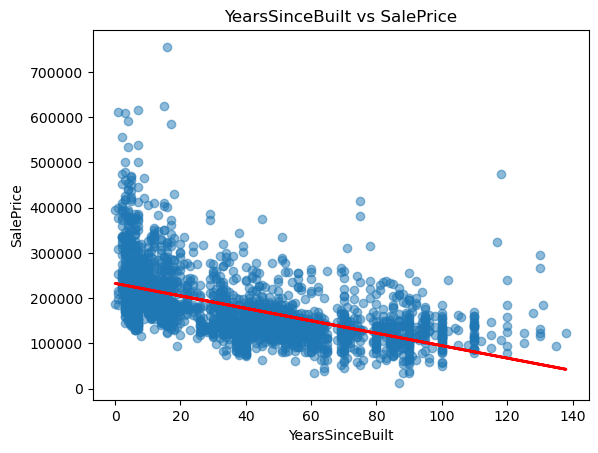

In [46]:
# Create scatter plot
plt.scatter(age['YearsSinceBuilt'], target, alpha=0.5)

# Plot the regression line
plt.plot(age['YearsSinceBuilt'], lr.predict(age), color='red', linewidth=2)

# Label the plot
plt.title('YearsSinceBuilt vs SalePrice')
plt.xlabel('YearsSinceBuilt')
plt.ylabel('SalePrice')

# Show the plot
plt.show()

#### Condition proxy features

*Candidates*
- OverallQual: Rates the overall material and finish of the house
- OverallCond: Rates the overall condition of the house

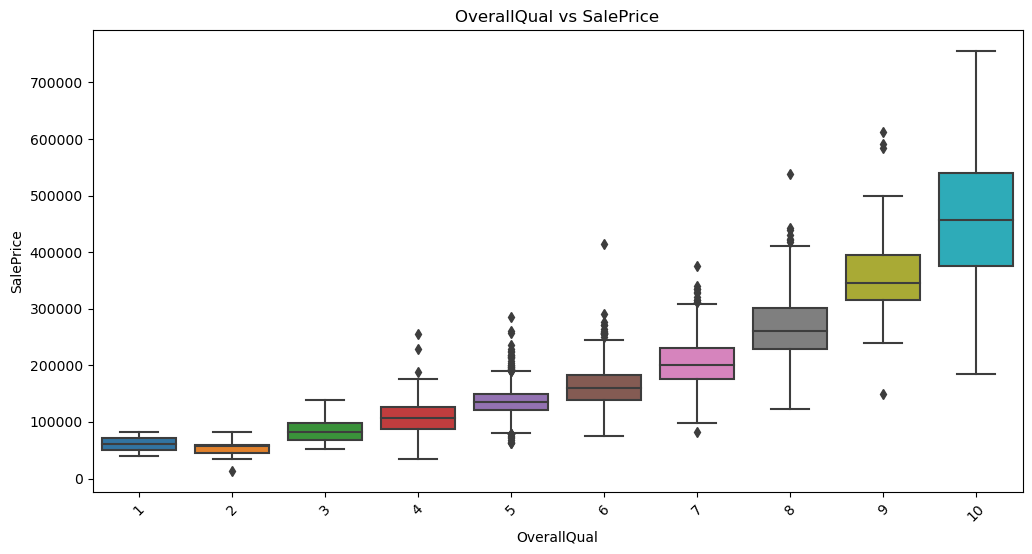

In [22]:
# Create a box plot of SalePrice vs. OverallQual
plt.figure(figsize=(12, 6))
sns.boxplot(x='OverallQual', y='SalePrice', data=ames_clean)

# Label the plot
plt.title('OverallQual vs SalePrice')
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

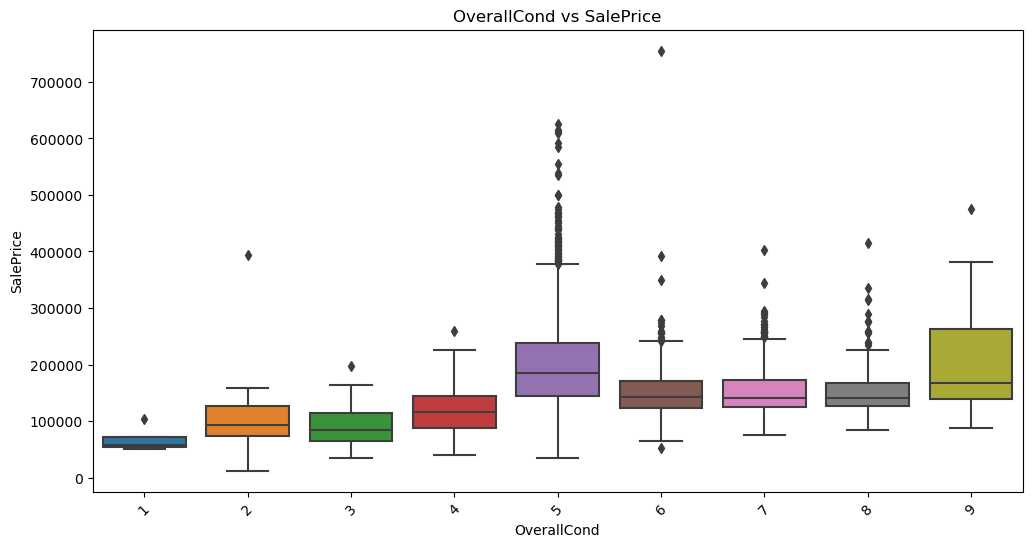

In [26]:
# Create a box plot of SalePrice vs. OverallCond
plt.figure(figsize=(12, 6))
sns.boxplot(x='OverallCond', y='SalePrice', data=ames_clean)

# Label the plot
plt.title('OverallCond vs SalePrice')
plt.xlabel('OverallCond')
plt.ylabel('SalePrice')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [28]:
# Dummify the 'OverallQual' column
overall_qual_dummies = pd.get_dummies(predictors['OverallQual'], prefix='OverallQual')

# Drop the first column of overall_qual_dummies
overall_qual_dummies = overall_qual_dummies.drop('OverallQual_1', axis=1)

overall_qual_dummies.head()

,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10
0,0,0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0


In [29]:
# Fit the model
lr.fit(overall_qual_dummies, target)

# Show the R^2 score
lr.score(overall_qual_dummies, target)

0.6888112865607101

#### Upgrades and Updates proxy features

*Candidates:*
- YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)

In [47]:
# Create a new feature representing YearsSinceRemod
YearsSinceRemod = max(predictors['YearRemodAdd']) - predictors['YearRemodAdd']
remod = pd.DataFrame({'YearsSinceRemod': YearsSinceRemod})

In [48]:
# Fit the model
lr.fit(remod, target)

# Show the R^2 score
lr.score(remod, target)

0.2649366345406384

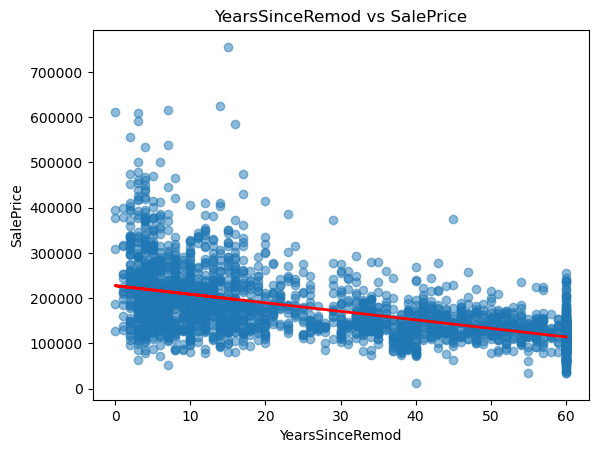

In [50]:
# Create scatter plot
plt.scatter(remod['YearsSinceRemod'], target, alpha=0.5)

# Plot the regression line
plt.plot(remod['YearsSinceRemod'], lr.predict(remod), color='red', linewidth=2)

# Label the plot
plt.title('YearsSinceRemod vs SalePrice')
plt.xlabel('YearsSinceRemod')
plt.ylabel('SalePrice')

# Show the plot
plt.show()

#### Microeconomic and macroeconomic proxy features

There are three microeconomic and macroeconomic considerations given:
1. Local market
2. Economic indicators
3. Interest rates

Since all the house sales happened in Ames, we might think that we have effectively controlled for these variables.  HOWEVER there is an important caveat: during the timeframe of the dataset (2006-2010), the US experienced the worst housing crisis in the post-Depression era.

We will engineer a simple feature 'crisis':
- If the date of sale is prior to 1 June 2007, crisis = 0
- If the date of sale is after this date, crisis = 1

The cut-off date was picked somewhat arbitrarily, but is rooted in the collapse of two of Bear Stearns' mortgage debt hedge funds in the month of June 2007 (see: https://www.wsj.com/articles/SB118230204193441422).  In retrospect, risks had been building in the housing market for some time before then, but the collapse of these funds is seen as a key event (see: https://www.cfr.org/timeline/us-financial-crisis).  The Case-Shiller National Home Price Index (see https://fred.stlouisfed.org/series/CSUSHPINSA) also seems to roughly confirm this timeline.

In [68]:
# Combine MoSold and YrSold into a single 'Date' column
macro = pd.DataFrame()
macro['DateSold'] = pd.to_datetime(predictors['YrSold'].astype(str) + '-' + predictors['MoSold'].astype(str) + '-01')

# Create a quarterly 'Period' column reflecting the date
macro['Period'] = pd.PeriodIndex(macro.DateSold, freq='Q')

# Check the result
print(macro.head())

    DateSold  Period
0 2010-03-01  2010Q1
1 2009-02-01  2009Q1
2 2007-11-01  2007Q4
3 2009-05-01  2009Q2
4 2009-11-01  2009Q4


In [69]:
# Define the crisis start date
crisis_start_date = pd.Timestamp('2007-07-15')

# Create a new column 'crisis', where 1 represents the crisis period and 0 represents the pre-crisis period
macro['crisis'] = (macro['DateSold'] >= crisis_start_date).astype(int)

# Check the result
print(macro.head())

    DateSold  Period  crisis
0 2010-03-01  2010Q1       1
1 2009-02-01  2009Q1       1
2 2007-11-01  2007Q4       1
3 2009-05-01  2009Q2       1
4 2009-11-01  2009Q4       1


In [70]:
# Combine macro with the target
macro['SalePrice'] = target

# Check the result
print(macro.head())

    DateSold  Period  crisis  SalePrice
0 2010-03-01  2010Q1       1     126000
1 2009-02-01  2009Q1       1     139500
2 2007-11-01  2007Q4       1     124900
3 2009-05-01  2009Q2       1     114000
4 2009-11-01  2009Q4       1     227000


<AxesSubplot:xlabel='crisis', ylabel='SalePrice'>

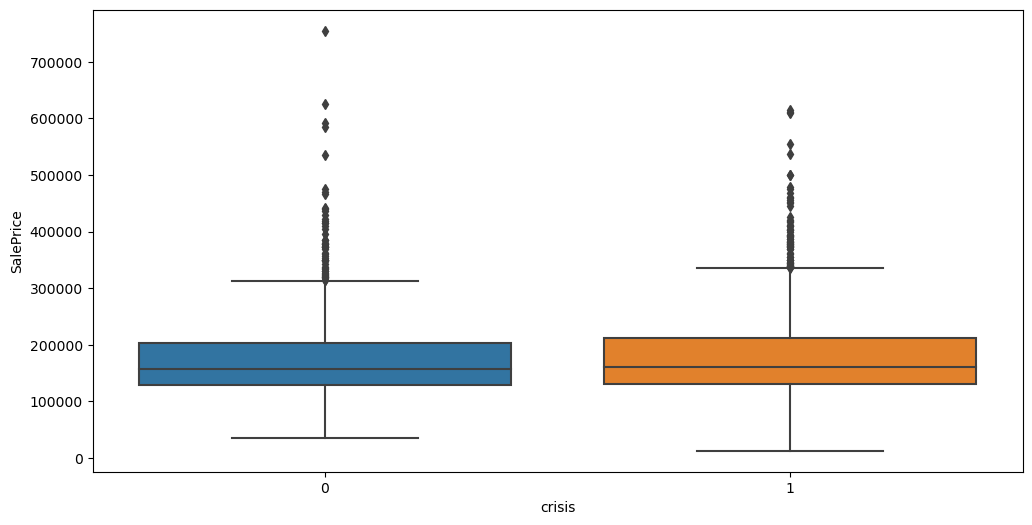

In [77]:
# Boxplot of SalePrice vs. crisis
plt.figure(figsize=(12, 6))
sns.boxplot(x='crisis', y='SalePrice', data=macro)

In [78]:
# Fit the model
lr.fit(macro[['crisis']], target)

# Print the R^2 score
lr.score(macro[['crisis']], target)

0.0002456458842525766

Our 'crisis' variable doesn't provide very much explanatory value.  Let's take a look at how pricing changes as a function of time e.g. stationarity.


In [79]:
# Group by 'Period' and calculate the median 'SalePrice'
median_prices = macro.groupby('Period')['SalePrice'].median().reset_index()

# Create a custom sorting function
def custom_sort(period):
    year, quarter = period.split('Q')
    return int(quarter), int(year)

# Sort periods using the custom sorting function
median_prices['Period'] = pd.PeriodIndex(median_prices['Period'], freq='Q')
median_prices['sort_key'] = median_prices['Period'].astype(str).apply(custom_sort)
median_prices = median_prices.sort_values('sort_key').drop('sort_key', axis=1)


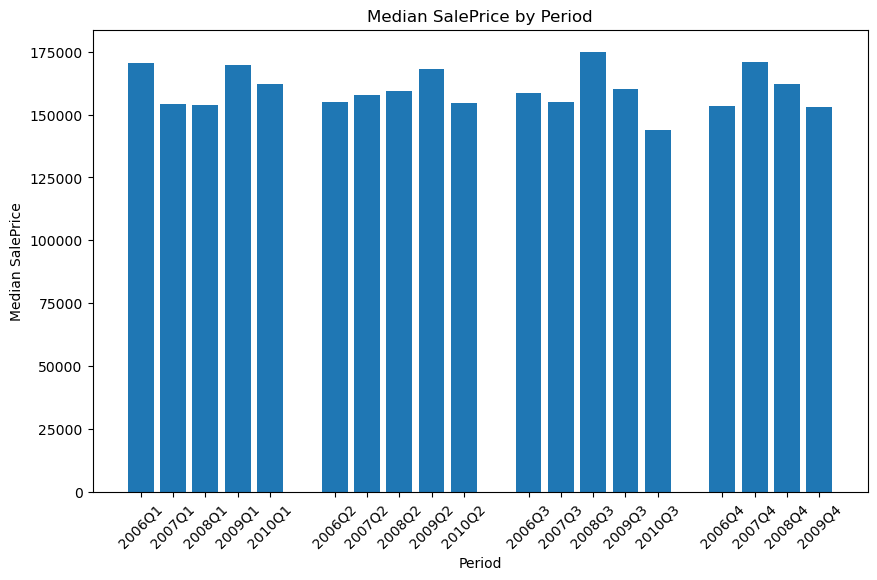

In [80]:
# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate the new x-axis values with spaces between quarters
x_values = []
for i, period in enumerate(median_prices['Period']):
    x_val = i + i // 5
    x_values.append(x_val)

# Plot the bars with the new x-axis values
ax.bar(x_values, median_prices['SalePrice'])

# Label the plot
ax.set_title('Median SalePrice by Period')
ax.set_xlabel('Period')
ax.set_ylabel('Median SalePrice')

# Set the x-axis labels with the new x-axis values
ax.set_xticks(x_values)
ax.set_xticklabels(median_prices['Period'], rotation=45)

# Show the plot
plt.show()


#### Collect the Best Features

In [81]:
# Create features based on best R^2 scores from each category - Neighborhood, GrLivArea, OverallQual
selected_features_small = pd.concat([neighborhood_dummies, predictors[['GrLivArea']], overall_qual_dummies], axis=1)


In [84]:
print(selected_features_small.columns)

Index(['Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
       'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_Greens',
       'Neighborhood_GrnHill', 'Neighborhood_IDOTRR', 'Neighborhood_Landmrk',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes',
       'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU',
       'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker',
       'GrLivArea', 'OverallQual_2', 'OverallQual_3', 'OverallQual_4',
       'OverallQual_5', 'OverallQual_6', 'OverallQual_7', 'OverallQual_8',
       'OverallQual_9', 'OverallQual_10'],
      dtype='object')


#### Check for Multicollinearity

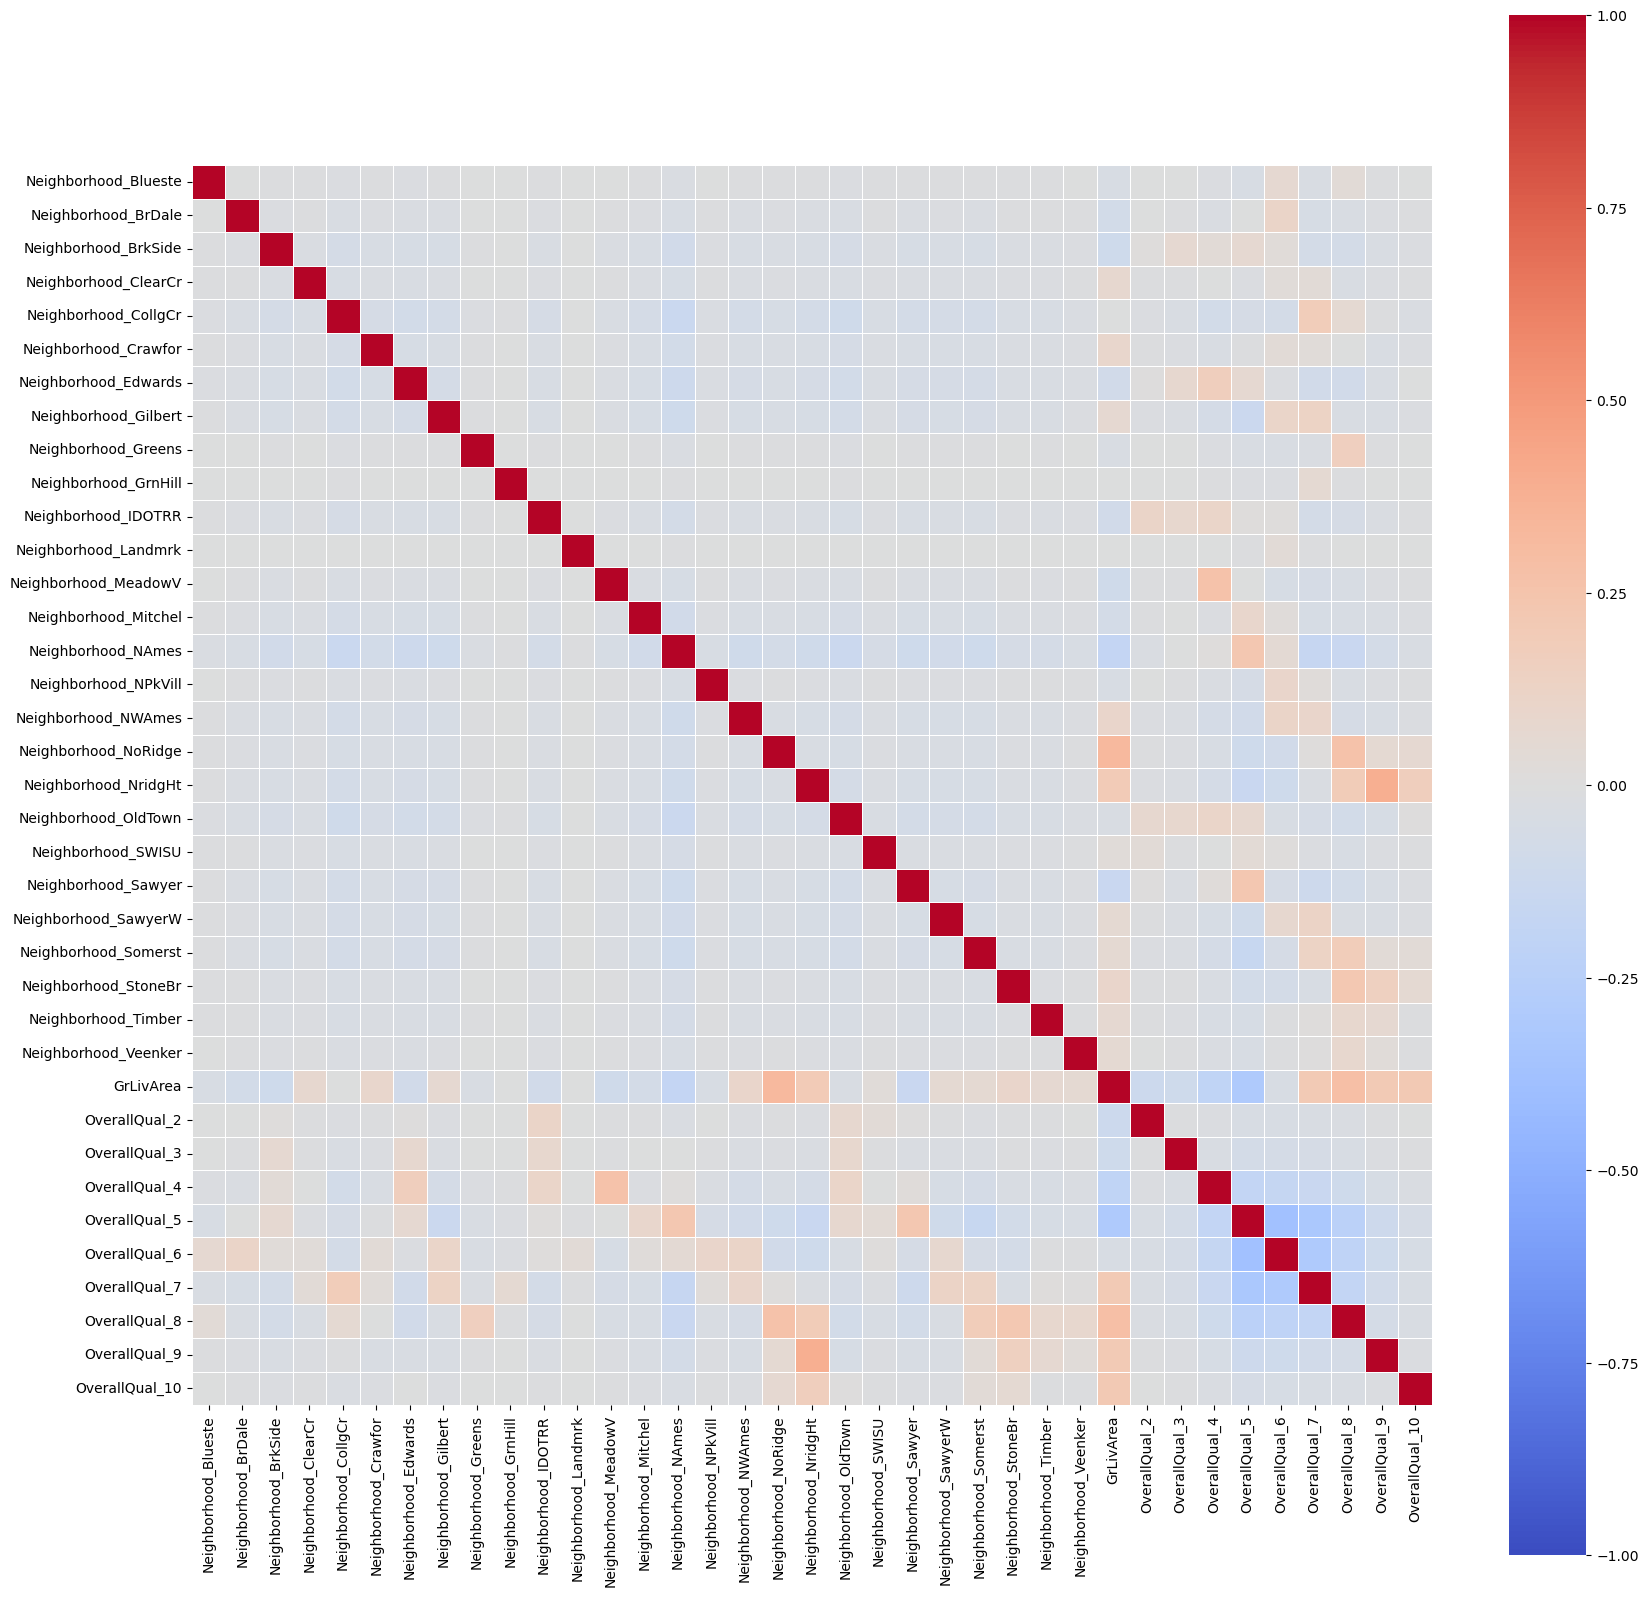

In [93]:
# Plot the correlation matrix
correlation_matrix = selected_features_small.corr()

plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, square=True, cmap='coolwarm', fmt='.2f', vmax=1.0, vmin=-1.0, linewidths=0.5)
plt.show()

In [85]:
# Calculate the VIF for each feature in the selected_features DataFrame
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(selected_features_small.values, i)
              for i in range(selected_features_small.shape[1])]

# Add the feature names to the VIF DataFrame
vif['Feature'] = selected_features_small.columns

# Sort the VIF DataFrame by VIF values in descending order
vif = vif.sort_values(by='VIF', ascending=False)

# Print the VIF DataFrame
print(vif)

          VIF               Feature
31  33.550275         OverallQual_5
32  30.093907         OverallQual_6
33  22.847147         OverallQual_7
14  17.849855    Neighborhood_NAmes
27  17.747423             GrLivArea
34  14.454240         OverallQual_8
4   10.210393  Neighborhood_CollgCr
19   9.754521  Neighborhood_OldTown
30   9.495359         OverallQual_4
6    7.757421  Neighborhood_Edwards
21   6.789387   Neighborhood_Sawyer
7    6.668961  Neighborhood_Gilbert
23   6.627655  Neighborhood_Somerst
18   6.180352  Neighborhood_NridgHt
16   5.932399   Neighborhood_NWAmes
22   5.477285  Neighborhood_SawyerW
2    5.153403  Neighborhood_BrkSide
13   5.147534  Neighborhood_Mitchel
35   5.116682         OverallQual_9
5    4.712971  Neighborhood_Crawfor
10   4.171820   Neighborhood_IDOTRR
17   3.913456  Neighborhood_NoRidge
25   3.159678   Neighborhood_Timber
24   2.845909  Neighborhood_StoneBr
20   2.737334    Neighborhood_SWISU
3    2.627529  Neighborhood_ClearCr
12   2.491702  Neighborhood_

## Training a Multilinear Regression Model

In [87]:
# Fit the model using selected_features_small
lr = LinearRegression()
lr.fit(selected_features_small, target)
lr.score(selected_features_small, target)   

0.8394869797533656

In [91]:
# Split the data into 70% train and 30% test sets
X_train, X_test, y_train, y_test = train_test_split(selected_features_small, target, test_size=0.3, random_state=0)

# Fit the model to the training data
lr.fit(X_train, y_train)


LinearRegression()

## Model Evaluation

Text(0.5, 1.0, 'Distribution of Residuals')

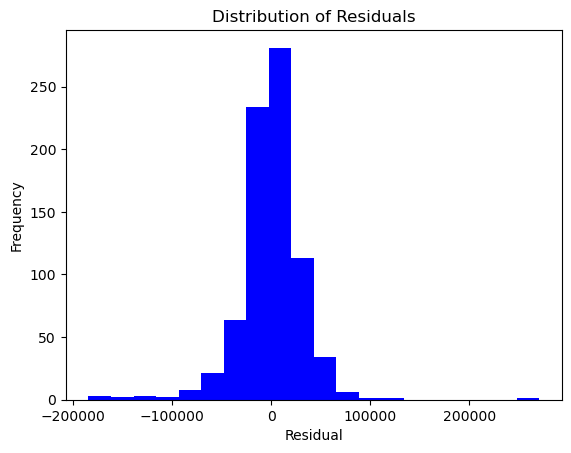

In [97]:
# Calculate the predictions on the test set
predictions = lr.predict(X_test)

# Calculate the residuals
residuals = predictions - y_test

# Plot a histogram of the residuals
plt.hist(residuals, bins=20, color='blue')

# Labels and title
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

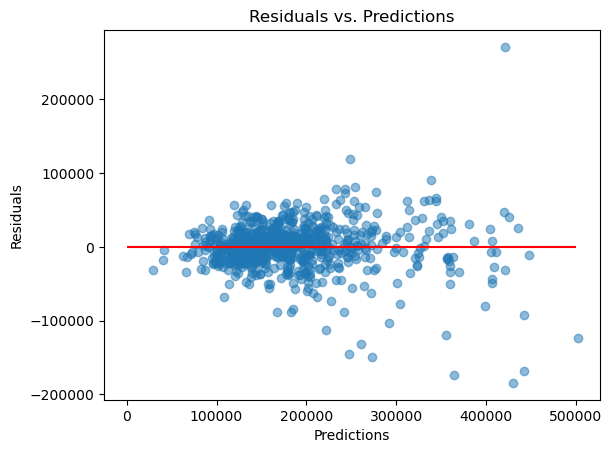

In [100]:
# Create the plot
plt.scatter(predictions, residuals, alpha=0.5)

# Labels and title
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predictions')

# Draw a horizontal line at y = 0
plt.hlines(y=0, xmin=0, xmax=500000, color='red')

# Show the plot
plt.show()

In [101]:
# Display the metrics
print('R^2 on test set is equal to %.3f' %(lr.score(X_test, y_test)))
print('RMSE on test set is equal to %.3f' %(np.sqrt(mean_squared_error(y_test, predictions))))
print('RSS is equal to %.3f' %(np.sum((y_test - predictions)**2)))
print('The intercept is equal to %.3f' %(lr.intercept_))
print('The slopes are %s' %(lr.coef_))

R^2 on test set is equal to 0.840
RMSE on test set is equal to 32188.419
RSS is equal to 801936978097.128
The intercept is equal to 42488.480
The slopes are [-3.16554773e+04 -4.91710320e+04 -2.66654274e+04  1.45089431e+04
  2.07364975e+03  4.34572315e+03 -2.68622424e+04 -5.95819299e+03
 -1.76561510e+04  4.58970029e+04 -4.16322557e+04  2.25481926e-08
 -3.97651400e+04 -2.53344076e+03 -1.51501555e+04 -2.88018085e+04
 -6.63628786e+03  3.82593606e+04  3.10681867e+04 -4.12392829e+04
 -4.41318681e+04 -1.25482661e+04 -6.04664291e+03  5.61783026e+03
  3.05954612e+04  2.01007066e+04  3.07178999e+04  5.56144674e+01
  6.07015471e+03  2.05240342e+04  2.95849710e+04  4.11780552e+04
  5.28307419e+04  6.95937822e+04  1.08955202e+05  1.83933025e+05
  2.19652454e+05]


## Conclusion

We are able to get a decently accurate model using only three predictors:
- 'Neighborhood', dummified
- 'GrLivArea'
- 'OverallQual'

Our mantra could basically be: "Location, Size, Condition!"

We will use this as a "baseline" for accuracy and interpretability for other ML models.

<br>
<br>


> **"Einstein said something along the lines of 'Make things as simple as possible, and no simpler.'  That's probably Rule Number 1 of modelling.**  
> **Rule Number 2 would be 'If you are going to make things more complicated then do so one new feature at a time.'**  
> **Already that's a big difference to machine learning in which one tends to throw in everything at the start, including the kitchen sink."**  
>
> Paul Wilmott, *Machine Learning: An Applied Mathematics Introduction*

------

## Save Engineered Features

We will save our new engineered features for use in other ML models

In [106]:
# Make a copy of the original predictors dataframe
predictors_eng = predictors.copy()
print(predictors_eng.columns)

Index(['GrLivArea', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [107]:
# Add neighborhood_dummies to the dataframe and drop original variable
predictors_eng = pd.concat([predictors_eng, neighborhood_dummies], axis=1)
predictors_eng.drop('Neighborhood', axis=1, inplace=True)
print(predictors_eng.columns)

Index(['GrLivArea', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       ...
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW',
       'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber',
       'Neighborhood_Veenker'],
      dtype='object', length=105)


In [108]:
# Add overall_qual_dummies to the dataframe and drop original variable
predictors_eng = pd.concat([predictors_eng, overall_qual_dummies], axis=1)
predictors_eng.drop('OverallQual', axis=1, inplace=True)
print(predictors_eng.columns)

Index(['GrLivArea', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       ...
       'Neighborhood_Veenker', 'OverallQual_2', 'OverallQual_3',
       'OverallQual_4', 'OverallQual_5', 'OverallQual_6', 'OverallQual_7',
       'OverallQual_8', 'OverallQual_9', 'OverallQual_10'],
      dtype='object', length=113)


In [110]:
# Add YearsSinceBuilt to the dataframe
predictors_eng = pd.concat([predictors_eng, age], axis=1)
print(predictors_eng.columns)

Index(['GrLivArea', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       ...
       'OverallQual_2', 'OverallQual_3', 'OverallQual_4', 'OverallQual_5',
       'OverallQual_6', 'OverallQual_7', 'OverallQual_8', 'OverallQual_9',
       'OverallQual_10', 'YearsSinceBuilt'],
      dtype='object', length=114)


In [112]:
# Add YearsSinceRemod to the dataframe
predictors_eng = pd.concat([predictors_eng, remod], axis=1)
print(predictors_eng.columns)   

Index(['GrLivArea', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       ...
       'OverallQual_3', 'OverallQual_4', 'OverallQual_5', 'OverallQual_6',
       'OverallQual_7', 'OverallQual_8', 'OverallQual_9', 'OverallQual_10',
       'YearsSinceBuilt', 'YearsSinceRemod'],
      dtype='object', length=115)


In [118]:
# Add DateSold, Period, crisis back to dataframe
predictors_eng = pd.concat([predictors_eng, macro[['DateSold', 'Period', 'crisis']]], axis=1)
print(predictors_eng.columns)

Index(['GrLivArea', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       ...
       'OverallQual_6', 'OverallQual_7', 'OverallQual_8', 'OverallQual_9',
       'OverallQual_10', 'YearsSinceBuilt', 'YearsSinceRemod', 'DateSold',
       'Period', 'crisis'],
      dtype='object', length=118)


In [120]:
# Combine the engineered features back to the target dataframe
ames_eng = pd.concat([predictors_eng, target], axis=1)
print(ames_eng.columns) 

Index(['GrLivArea', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       ...
       'OverallQual_7', 'OverallQual_8', 'OverallQual_9', 'OverallQual_10',
       'YearsSinceBuilt', 'YearsSinceRemod', 'DateSold', 'Period', 'crisis',
       'SalePrice'],
      dtype='object', length=119)


In [121]:
for column_name in ames_eng.columns:
    print(column_name)

GrLivArea
MSSubClass
MSZoning
LotFrontage
LotArea
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Condition1
Condition2
BldgType
HouseStyle
OverallCond
YearBuilt
YearRemodAdd
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
MasVnrArea
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinSF1
BsmtFinType2
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
Heating
HeatingQC
CentralAir
Electrical
1stFlrSF
2ndFlrSF
LowQualFinSF
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
KitchenQual
TotRmsAbvGrd
Functional
Fireplaces
FireplaceQu
GarageType
GarageYrBlt
GarageFinish
GarageCars
GarageArea
GarageQual
GarageCond
PavedDrive
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
PoolQC
Fence
MiscFeature
MiscVal
MoSold
YrSold
SaleType
SaleCondition
Neighborhood_Blueste
Neighborhood_BrDale
Neighborhood_BrkSide
Neighborhood_ClearCr
Neighborhood_CollgCr
Neighborhood_Crawfor
Neighborhood_Edwards
Neighborhood_Gilbert
Neighborhood_Gre

In [123]:
# Save the engineered dataset to a csv file
ames_eng.to_csv('data/Ames_Housing_Price_Data_eng.csv', index=False)